# Prelude

In [1]:
import glob
import scipy.ndimage

import numpy as np
import pylab as plt

import lemur_util

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Introduction

[[TODO: Describe the problem and where you got the images from]]

## Load Images

The images are assumed to be in the ``faces`` directory. There are 200 faces, the $i$-th neutral face is named ``ia_t.jpeg`` and the corresponding smiling face is named ``ib_t.jpeg``.

In [2]:
N_IMAGES = 200
NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

In [3]:
# Load neutral faces
neutral = []
for filename in sorted(glob.glob(NEUTRAL_FACES_GLOB)):
  neutral.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
neutral = np.array(neutral)

# Load smiling faces
smiling = []
for filename in sorted(glob.glob(SMILING_FACES_GLOB)):
  smiling.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
smiling = np.array(smiling)

# PCA

We use a dataset with about 7000 faces available in [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection) to perform PCA. The dataset was modified to ignore the facial keypoints and keep only the pictures. It is assumed to be saved in ``faces.txt``.

In [4]:
KAGGLE_FACES = 'faces.txt'
N_FEATURES = 3000

We used the method described in [arXiv:1007.5510v2](http://arxiv.org/abs/1007.5510v2) to perform PCA. This method is implemented by ``lemur_PCA`` in ``lemur_pca.py``.

This function loads the faces from ``KAGGLE_FACES`` into a matrix $A$, performs an approximation of the SVD decomposition given by $A = U\Sigma V^T$, using the ``N_FEATURES`` most important eigenvalues, and returns the matrix $V$.

In [5]:
from lemur_pca import lemur_PCA

V = lemur_PCA(KAGGLE_FACES, N_FEATURES, 2)

We may choose to shuffle the images before continuing.

In [6]:
# Shuffle images
p = np.random.permutation(smiling.shape[0])

neutral = neutral[p]
smiling = smiling[p]

We proceed to find the representation of the images given by PCA.

In [7]:
neutral_pca = neutral.dot(V)
smiling_pca = smiling.dot(V)

# SOAR

[SOAR](https://research.cs.washington.edu/istc/lfb/paper/cvpr09.pdf) (Structured-Output Associative Regression) is a method to exploit the structure in the output space to improve the predictions made by the algorithm. 
To achieve this, an output feature is made dependent not only on the input features, but on the rest of the outputs as well.

Let $\mathbf{x}\in\mathbb{R}^n$ be an input and $\mathbf{y}\in\mathbb{R}^m$ the corresponding output. Traditionally, we find a matrix $W$ and a vector $b$ such that $\mathbf{y} = W\mathbf{x} + \mathbf{b}$. We can rewrite this as $y_i = \mathbf{w_i}^T\mathbf{x} + b_i$ to make clear that the $i$-th output coordinate depends only on the input, and the possible relationship with the rest of the coordinates is ignored.

Let $\mathbf{y_{-i}}$ denote the vector that results by dropping the $i$-th coordinate from $y$. In SOAR we capture the relationships between the output coordinates by finding $U$, $V$ and $b$ such that $y_i = \mathbf{u_i}^T\mathbf{x} + \mathbf{v_i}^T\mathbf{y^{-i}} + b_i$.

Using the kernel trick we can incorpore non-linearities by replacing dot products with kernel functions, so that $y_i = \mathbf{u_i}^T\phi_x(\mathbf{x}) + \mathbf{v_i}^T\phi_y^i(\mathbf{y^{-i}})$, where $\phi_x:\mathbb{R}^n\longrightarrow\mathcal{F}_x$ is the feature function corresponding to the kernel $k_x$ and $\phi_y^i:\mathbb{R}^n\longrightarrow\mathcal{F}_y^i$ is the feature function corresponding to the kernel $k_y^i$. 

Note that a different kernel for each coordinate might be used.

## Training

The vectors $\mathbf{u_i}$ and $\mathbf{v_i}$ can be found by solving the following optimization problem for each $i$;

$$\begin{array}{l c}
\min._{(\mathbf{u_i}, \mathbf{v_i}, \xi)} & 
\frac{1}{2} \sum_{k=1}^n \xi_k^2 + \frac{\alpha_{i}}{2}\Vert \mathbf{u_i}\Vert^2 
+ \frac{\beta_{i}}{2}\Vert \mathbf{v_i}\Vert^2 \\
\mathrm{s.t.} & 
\xi_k = y[k]_i - \mathbf{u_i}^T\phi_x\left(\mathbf{x[k]}\right) 
        - \mathbf{v_i}^T\phi_y^i\left(\mathbf{y[k]_{-i}}\right) \\
\end{array}$$

Let $\phi_x$ be the feature function corresponding to $k_x$ and $\phi_y$ the feature function corresponding to $k_y$. The solution to the optimization problem is given by 
$\begin{array}{l}
\mathbf{u_i} = \frac{1}{\alpha_i}\sum_{k=1}^n a^i_k\phi_x\left(\mathbf{x[k]}\right) \\
\mathbf{v_i} = \frac{1}{\beta_i}\sum_{k=1}^n a^i_k\phi_y^i\left(\mathbf{y_{-i}[k]}\right) \\
\xi_k = a^i_k \\
\end{array}$

Where the coefficients $a^i_k$ are given by
$\mathbf{a^i} = \left(\frac{1}{\alpha_i}K^i_x + \frac{1}{\beta_i}K_y + I_n\right)^{-1}\mathbf{Y_i}$ and $\mathbf{Y_i}$ is the vector of the $i$-th coordinates of the output in the training data.

## Prediction

Given an input $\mathbf{x}$, we initialize $\mathbf{y}^{(0)}$ to be an initial prediction.

The current prediction $\mathbf{y}^{(t)}$ is updated by calculating 

$\begin{array}{r c l}
y_i^{(t+1)} & = & \mathbf{u_i}^T\phi_x(\mathbf{x}) + \mathbf{v_i}^T\phi_y^i\left(\mathbf{y_{-i}}^{(t)}\right) \\
& = & 
\frac{1}{\alpha_i}\sum_{k=1}^n a^i_k k_x\left(\mathbf{x[k]}, \mathbf{x}\right) 
+ \frac{1}{\beta_i}\sum_{k=1}^n a^i_k k_y^i\left(\mathbf{y_{-i}[k]}, \mathbf{y_{-i}}^{(t)}\right) \\
\end{array}$

And the process is repeated until convergence.


# LemurSOAR

The equation by which SOAR relates a given output coordinate to the input and the rest of output coordinates is the following:
$y_i = \mathbf{u_i}^T\phi_x(\mathbf{x}) + \mathbf{v_i}^T\phi_y^i(\mathbf{y^{-i}})$

This can be rewritten as
$y_i = \left[\begin{array}{c} \mathbf{u_i} \\ \mathbf{v_i} \end{array}\right]^T
       \left[\begin{array}{c} \phi_x(\mathbf{x}) \\ \phi_y^i(\mathbf{y_{-i}}) \end{array}\right]
     = \mathbf{w_i}^T\phi_i(\mathbf{x}, \mathbf{y_{-i}})$.
     
For SOAR, we obtain a function $\phi_i:\mathbb{R}^n\times\mathbb{R}^{m-1}\longrightarrow\mathcal{F}_i$ given by $\phi_i(\mathcal{x},\mathcal{y}) = (\phi_x(\mathcal{x}), \phi_y^i(\mathcal{y}))$, where $\mathcal{F}_i=\mathcal{F}_x\times\mathcal{F}_y^i$, and the corresponding kernel function $k_i:\mathbb{R}^n\times\mathbb{R}^{m-1}\longrightarrow\mathbb{R}$ is given by $k_i((\mathcal{x_1},\mathcal{y_1}), (\mathcal{x_2}, \mathcal{y_2})) = k_x(\mathcal{x_1}, \mathcal{x_2}) + k_y^i(\mathcal{y_1}, \mathcal{y_2})$.

We can easily generalize this to other feature spaces $\mathcal{F}_i$, not only cartesian product.

## Training And Prediction

Let $d$ be the dimension of the images, $d=96\times 96=9216$ in our case, and $n$ the number of training images.
Let $X\in\mathbb{R}^{n\times d}$ be the training input dataset, and $Y_{-i}\in\mathbb{R}^{n\times(d-1)}$ be the training output dataset, excluding the $i$-th coordinate.

Denote $\Phi_i$ as the result of applying $\phi_i$ to $X$ and $Y$, so that $\Phi_i[k] = \phi_i(X[k], Y_{-i}[k])$,  where $A[k]$ denotes the $k$-th row of the matrix $A$.

Let $\mathrm{y_i}\in\mathbb{R}^n$ denote the vector with the $i$-th coordinate in the training output dataset. The task is then to find a $\mathrm{w_i}$ that solves the following problem:

$$\begin{array}{l c}
\mathrm{min.}_{\mathbf{w_i}} & 
\frac{1}{2}\Vert \Phi_i \mathbf{w_i} - \mathbf{y_i}\Vert^2 + \frac{\alpha_i}{2} \Vert w_i\Vert^2\\
        \end{array}$$

Which is the same as the objective function for KRR, using $k_i$ as the kernel, so that the solution is given by $\mathrm{w_i} = (\Phi_i^T\Phi_i + \alpha_i I_{\mathcal{F}_i})^{-1}\Phi_i^T \mathbf{y_i} = \Phi_i^T(\Phi_i\Phi_i^T + \alpha_i I_n)^{-1}\mathbf{y_i}$.

Define $K_i = \Phi_i\Phi_i^T$ be the Gram matrix for the training dataset, and $\kappa(\mathbf{x}, \mathbf{y_{-i}})=\phi_i(\mathbf{x}, \mathbf{y_{-i}})\Phi_i^T$ the row vector resulting of evaluating the kernel function between $(\mathbf{x}, \mathbf{y_{-i}})$ and the training dataset.
Then we have $\mathrm{w_i} = \Phi_i^T(K_i + \alpha_i I_n)^{-1} \mathbf{y_i}$. 

We can define $W_i = (K_i + \alpha_i I_n)^{-1} \mathbf{y_i}$, so that the prediction for an input $(\mathbf{x}, \mathbf{y_{-i}})$ is given by $\kappa(\mathbf{x}, \mathbf{y_{-i}})W_i$.

Given an input image $\mathbf{x}$, an initial guess $\mathbf{y^{(0)}}$ is obtained by some method. We train a simple KRR from neutral faces to smiling faces to produce this initial guess.
To update the current guess $\mathbf{y^{(t)}}$, we simply compute $y^{(t+1)}_i=\kappa(\mathbf{x}, \mathbf{y^{(t)}_{-i}})W$ and repeat this process until convergence.


# Implementation

We begin by splitting the available data in training and test.

In [8]:
from lemur_soar import LemurSOAR

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST

neutral_training = neutral[:N_TRAINING]
smiling_training = smiling[:N_TRAINING]

neutral_training_pca = neutral_pca[:N_TRAINING]
smiling_training_pca = smiling_pca[:N_TRAINING]

neutral_test = neutral[N_TRAINING:]
smiling_test = smiling[N_TRAINING:]

neutral_test_pca = neutral_pca[N_TRAINING:]
smiling_test_pca = smiling_pca[N_TRAINING:]

We can append the smiling images to be part of the input.

In [9]:
neutral_training = np.append(neutral_training, smiling[:N_TRAINING], axis=0)
smiling_training = np.append(smiling_training, smiling[:N_TRAINING], axis=0)

neutral_training_pca = np.append(neutral_training_pca, smiling_pca[:N_TRAINING], axis=0)
smiling_training_pca = np.append(smiling_training_pca, smiling_pca[:N_TRAINING], axis=0)

## Kernels

Kernels for `LemurSOAR` are classes that support two methods, `set_x` and `set_y`, that receive the neutral and smiling images, and when called as a function with `k` must return the Gram matrix to be used when predicting the `k`-th coordinate.

### Ridge Regression

LemurSOAR can be used to perform RidgeRegression, by making $k_i((\mathbf{x_1},\mathbf{y_1}), (\mathbf{x_2}, \mathbf{y_2})) = \mathbf{x_1}^T\mathbf{x_2}$.

feature 0
feature 1000
feature 2000
feature 3000
feature 4000
feature 5000
feature 6000
feature 7000
feature 8000
feature 9000


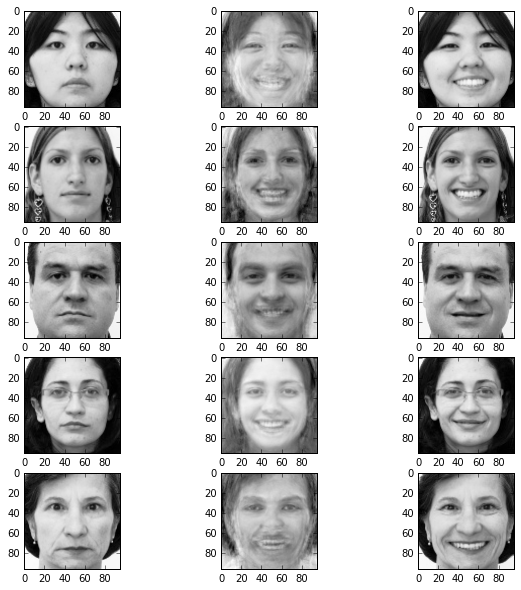

In [10]:
class RR:
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T)
  def set_y(self, Y1, Y2):
    pass
  def __call__(self, k):
    return self.X + 1
  
rr = LemurSOAR(neutral_training, smiling_training, RR(), override=True)
rr_predictions = rr.predict(neutral_test)
lemur_util.plot_predictions(neutral_test, rr_predictions, smiling_test)

### Ridge Regression (After PCA)

We can perform PCA before applying LemurSOAR, so that the training and prediction becomes faster. We can see below that the performance is almost identical.

feature 0
feature 1000
feature 2000


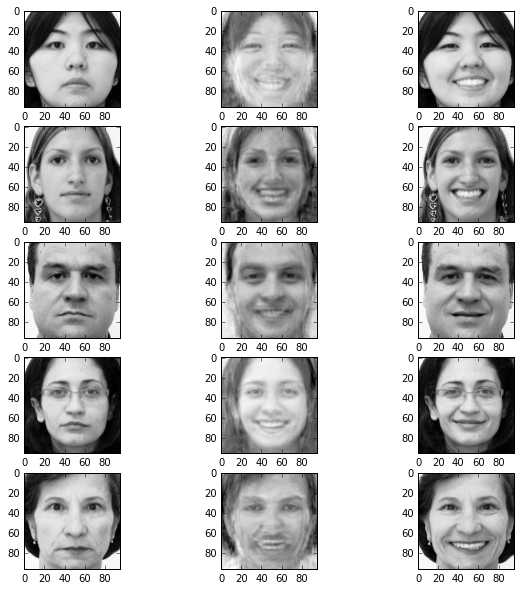

In [11]:
pca_rr = LemurSOAR(neutral_training_pca, smiling_training_pca, RR(), override=True)
pca_rr_predictions = pca_rr.predict(neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, pca_rr_predictions, smiling_test)

### Linear + Linear

We now incorporate the remaining output coordinates in the simplest way possible, by defining $k_i((\mathbf{x_1},\mathbf{y_1}), (\mathbf{x_2}, \mathbf{y_2})) = \mathbf{x_1}^T\mathbf{x_2} + \mathbf{y_1}^T\mathbf{y_2}$

feature 0
feature 1000
feature 2000
feature 3000
feature 4000
feature 5000
feature 6000
feature 7000
feature 8000
feature 9000


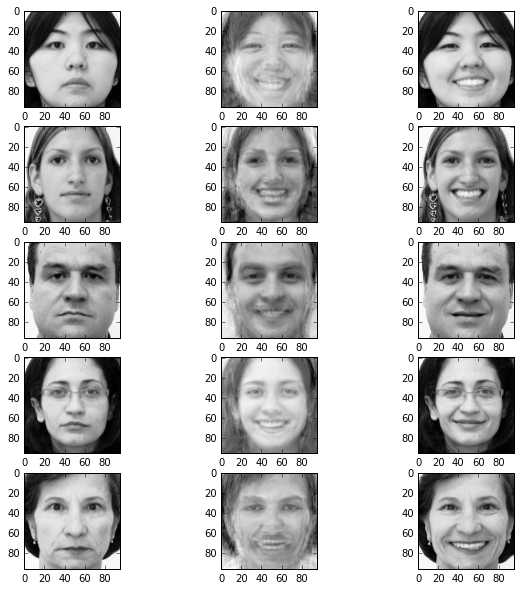

In [12]:
class LpL:
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T)
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    K = np.outer(self.Y1[k], self.Y2[k])
    return self.X + self.Y - K
  
lpl = LemurSOAR(neutral_training, smiling_training, LpL(), override=True)
lpl_predictions = lpl.predict(neutral_test)
lemur_util.plot_predictions(neutral_test, lpl_predictions, smiling_test)

### Linear + Linear (After PCA)

As before, we apply PCA to make it faster.

feature 0
feature 1000
feature 2000


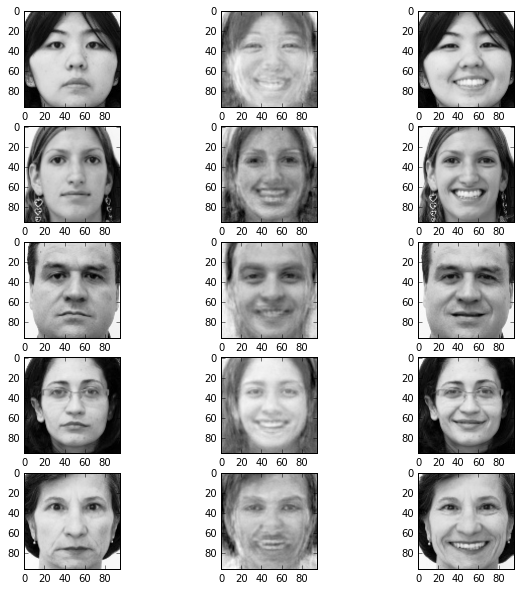

In [13]:
pca_lpl = LemurSOAR(neutral_training_pca, smiling_training_pca, LpL(), override=True)
pca_lpl_predictions = pca_lpl.predict(neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, pca_lpl_predictions, smiling_test)

### RBF * Linear (After PCA)

We now define $k_i((\mathbf{x_1},\mathbf{y_1}), (\mathbf{x_2}, \mathbf{y_2})) = \mathrm{RBF}(\mathbf{x_1}, \mathbf{x_2}) * \mathbf{y_1}^T\mathbf{y_2}$.

This is the first generalization of LemurSOAR over SOAR, since this kernel cannot be expressed by SOAR.

feature 0
feature 1000
feature 2000


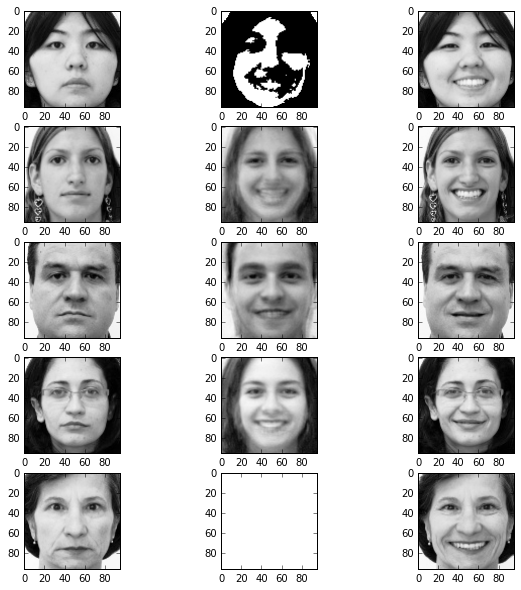

In [14]:
class PCA_RBFtL:
  def set_x(self, X1, X2):
    self.X = np.exp(-.5 * self._dmatrix(X1, X2) / 400)
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    K = np.outer(self.Y1[k], self.Y2[k])
    return self.X * (self.Y - K)
  def _dmatrix(self, X, Y):
    K = np.zeros((Y.shape[0], X.shape[0]))
    for i in range(Y.shape[0]):
      K[i] = np.sum((X - Y[i])**2, axis=1)
    return K.T
  
pca_rbftl = LemurSOAR(neutral_training_pca, smiling_training_pca, PCA_RBFtL(), override=True)
pca_rbftl_predictions = pca_rbftl.predict(neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, pca_rbftl_predictions, smiling_test)

# LemurSOAR (With a Twist)

In this particular case, is not unreasonable to suppose that the input and output images should be very similar in most locations. If we restrict ourselves to use a kernel of the form $k_i((\mathbf{x_1}, \mathbf{y_1}), (\mathbf{x_2}, \mathbf{y_2})) = \mathbf{x_1}^T\mathbf{x_2} + k_y(\mathbf{y_1}, \mathbf{y_2})$ we can easily modify the objective function to reflect this.

Note that for this kind of kernels, we can write $\Phi_i=\left[\begin{array}{c c}X & \Psi_y\end{array}\right]$ where $\Psi_y$ is the matrix associated with the kernel $k_y$; and $K_i = XX^T + K_y$, where $K_y$ is the Gram matrix associated with $k_y$.

We can reflect the supossition that the $i$-th output coordinate depends mostly on the $i$-th we change the regularization to be $\Vert\mathbf{w_i} - \mathbf{e_i}\Vert^2$ instead of $\Vert\mathbf{w_i}\Vert^2$, where $e_i$ is the vector with a $1$ in the $i$-th coordinate and $0$ on the rest.

This only makes sense because the $i$-th input coordinate in the feature space corresponds to the $i$-th input coordinate in the dataset.

The objective function is then given as follows, where $\mathbf{m_i}=\mathbf{w_i}-\mathbf{e_i}$:
$$\begin{array}{l c c}
\mathrm{min.}_{\mathbf{w_i}} & &
\frac{1}{2}\Vert \Phi_i \mathbf{w_i} - \mathbf{y_i}\Vert^2 + \frac{\alpha_i}{2} \Vert \mathbf{w_i} - \mathbf{e_i}\Vert^2\\
& = & 
\frac{1}{2}\Vert \Phi_i (\mathbf{m_i} + \mathrm{e_i}) - \mathbf{y_i}\Vert^2 + \frac{\alpha_i}{2} \Vert \mathbf{m_i} \Vert^2\\
& = & 
\frac{1}{2}\Vert \Phi_i \mathbf{m_i} + \Phi_i\mathrm{e_i} - \mathbf{y_i}\Vert^2 + \frac{\alpha_i}{2} \Vert \mathbf{m_i} \Vert^2\\
& = & 
\frac{1}{2}\Vert \Phi_i \mathbf{m_i} + \mathrm{x_i} - \mathbf{y_i}\Vert^2 + \frac{\alpha_i}{2} \Vert \mathbf{m_i} \Vert^2\\
& = & 
\frac{1}{2}\Vert \Phi_i \mathbf{m_i} - (\mathbf{y_i} - \mathrm{x_i})\Vert^2 + \frac{\alpha_i}{2} \Vert \mathbf{m_i} \Vert^2\\
        \end{array}
$$

So that we can train LemurSOAR with $Y - X$ as input and add $X$ after the prediction is made. If we do this we can preserve details that would be lost otherwise.

## RR (With a Twist)

We start by employing the idea above with RidgeRegression. Note that details like the hair and jewelery are better preserved.

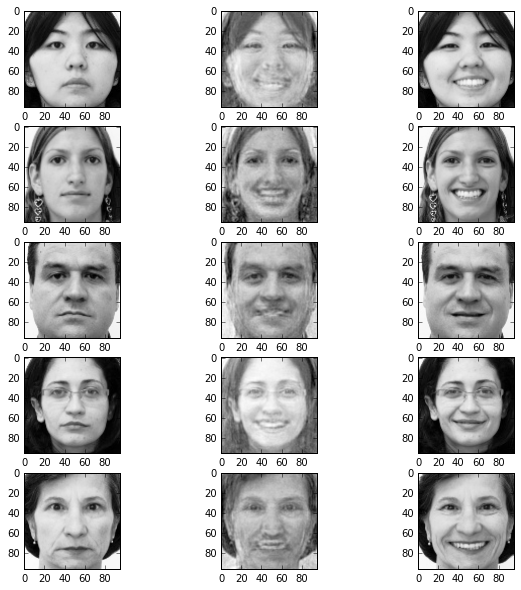

In [15]:
import sklearn.linear_model

twist_ridge = sklearn.linear_model.Ridge(alpha=.1).fit(neutral_training_pca, smiling_training_pca - neutral_training_pca)
twist_ridge_predictions = (twist_ridge.predict(neutral_test_pca) + neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, twist_ridge_predictions, smiling_test)

## Linear + Linear (With a Twist)

We now apply this idea to the Linear + Linear kernel in LemurSOAR. Note again that the details are better preserved.

feature 0
feature 1000
feature 2000


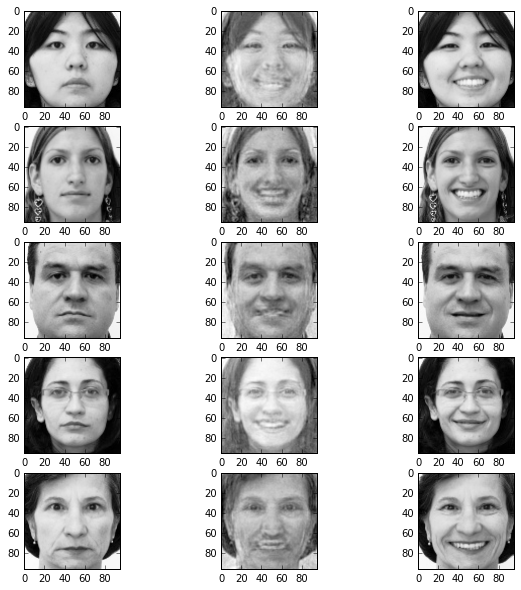

In [16]:
class LpL2:
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T)
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    K = np.outer(self.Y1[k], self.Y2[k])
    return self.X + self.Y - K
  
lpl_twist = LemurSOAR(neutral_training_pca, smiling_training_pca - neutral_training_pca, LpL2(), override=True)
lpl_twist_predictions = (lpl_twist.predict(neutral_test_pca) + neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, lpl_twist_predictions, smiling_test)

# Ensembles

Now we combine the Linear + Linear LemurSOAR with the RBF * Linear LemurSOAR to provide a better prediction. The motivation is for Linear + Linear to preserve the details and RBF * Linear to smooth the result.

In [17]:
def normalize(imgs):
  imgs = imgs.reshape(-1, 9216)
  mins = np.min(imgs, axis=1)
  imgs = (imgs.T - mins).T
  maxs = np.max(imgs, axis=1)
  imgs = (imgs.T / maxs).T
  imgs.reshape(-1, 96, 96)
  return imgs

ensemble_1 = normalize(pca_rbftl_predictions)
ensemble_2 = normalize(lpl_twist_predictions)

Here we can see the results of a weighted average of the predictions.

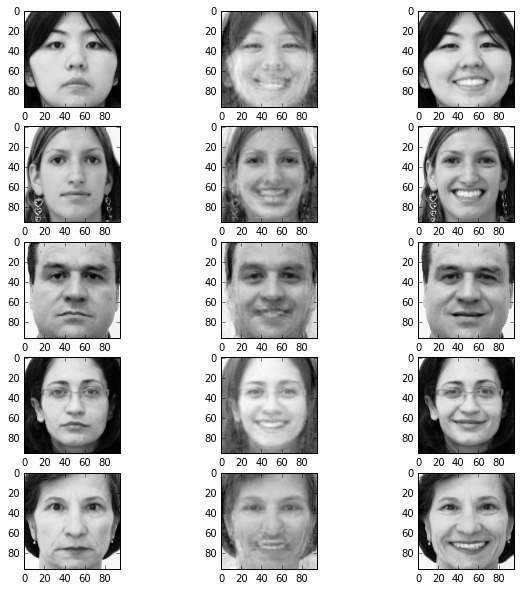

In [18]:
ensemble_alpha = .3
ensemble = ensemble_alpha * ensemble_1 + (1 - ensemble_alpha) * ensemble_2
lemur_util.plot_predictions(neutral_test, ensemble, smiling_test)

Here we can see the predictions made by Linear + Linear on the left, the Ensemble in the middle, and the RBF * Linear on the right.

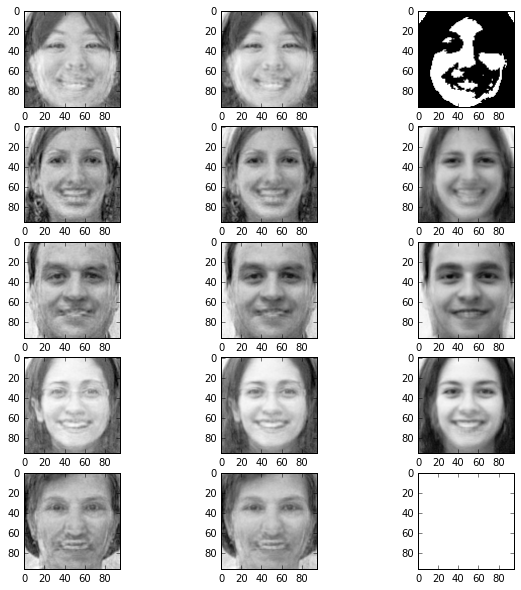

In [19]:
lemur_util.plot_predictions(lpl_twist_predictions, ensemble, pca_rbftl_predictions)

We now repeat the same procedure using a weighted geometric mean.

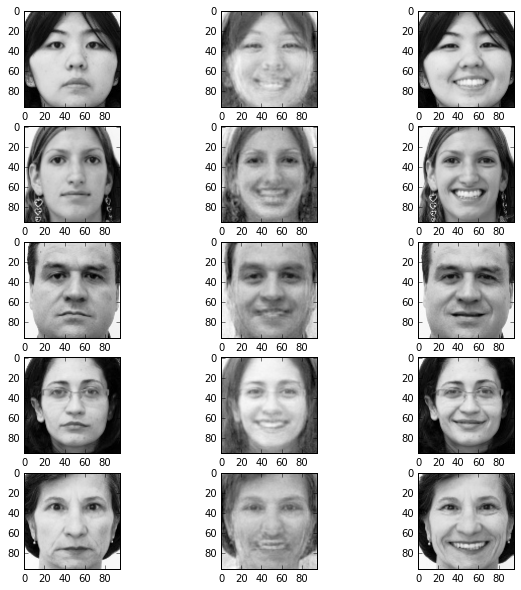

In [20]:
ensemble_alpha2 = .3
ensemble2 = ensemble_1 ** ensemble_alpha * ensemble_2 ** (1 - ensemble_alpha)
lemur_util.plot_predictions(neutral_test, ensemble2, smiling_test)

# Misc. Images

We proceed to test the algorithm on some misc. images. Some are downloaded from the internet, and the URL is provided.

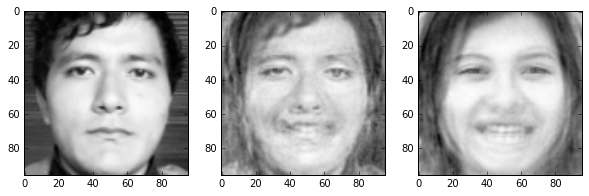

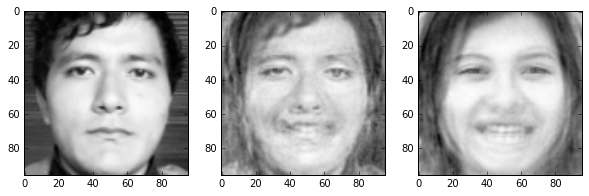

In [21]:
lemur_face = scipy.ndimage.imread('lemur_face.jpeg', flatten=True).reshape(1, 9216) / 255
lemur_face_pca = lemur_face.dot(V)
lemur_smile_1 = (lpl_twist.predict(lemur_face_pca) + lemur_face_pca).dot(V.T)
lemur_smile_2 = (pca_rbftl.predict(lemur_face_pca)).dot(V.T)
lemur_util.plot_predictions(lemur_face, lemur_smile_1, lemur_smile_2)
lemur_util.plot_predictions(lemur_face, lemur_smile_1*.7 + lemur_smile_2*.3, lemur_smile_2)

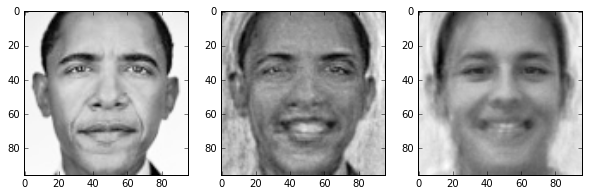

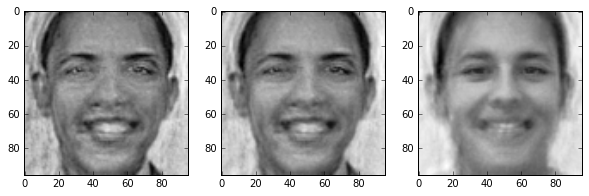

In [22]:
# http://portra.wpshower.com/wp-content/uploads/2014/03/martin-schoeller-barack-obama-portrait-up-close-and-personal.jpg
obama = scipy.ndimage.imread('obama.jpeg', flatten=True).reshape(1, 9216) / 255
obama_pca = obama.dot(V)
obama_1 = normalize((lpl_twist.predict(obama_pca) + obama_pca).dot(V.T))
obama_2 = normalize((pca_rbftl.predict(obama_pca)).dot(V.T))
lemur_util.plot_predictions(obama, obama_1, obama_2)
lemur_util.plot_predictions(obama_1, obama_1*.7 + obama_2*.3, obama_2)

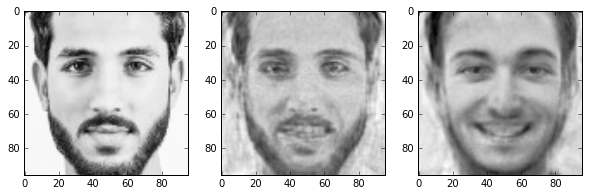

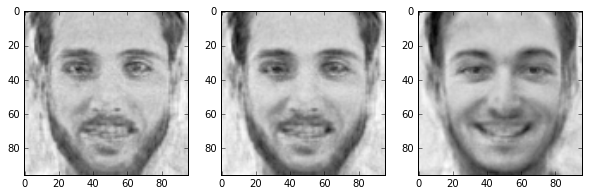

In [23]:
# https://freeuse.io/img_highres/5731-black-and-white-man-person-portrait.jpg
some_guy = scipy.ndimage.imread('some_guy.jpeg', flatten=True).reshape(1, 9216) / 255
some_guy_pca = some_guy.dot(V)
some_guy_1 = normalize((lpl_twist.predict(some_guy_pca) + some_guy_pca).dot(V.T))
some_guy_2 = normalize((pca_rbftl.predict(some_guy_pca)).dot(V.T))
lemur_util.plot_predictions(some_guy, some_guy_1, some_guy_2)
lemur_util.plot_predictions(some_guy_1, some_guy_1*.7 + some_guy_2*.3, some_guy_2)

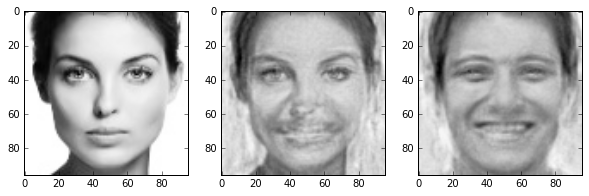

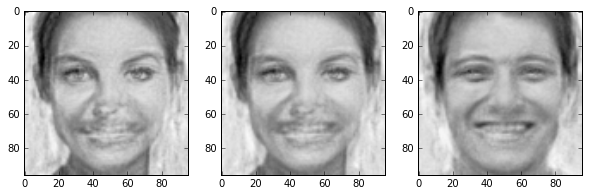

In [24]:
# https://i.ytimg.com/vi/TZiQK81Rjfw/maxresdefault.jpg
some_woman = scipy.ndimage.imread('some_woman.jpeg', flatten=True).reshape(1, 9216) / 255
some_woman_pca = some_woman.dot(V)
some_woman_1 = normalize((lpl_twist.predict(some_woman_pca) + some_woman_pca).dot(V.T))
some_woman_2 = normalize((pca_rbftl.predict(some_woman_pca)).dot(V.T))
lemur_util.plot_predictions(some_woman, some_woman_1, some_woman_2)
lemur_util.plot_predictions(some_woman_1, some_woman_1*.7 + some_woman_2*.3, some_woman_2)